<a href="https://colab.research.google.com/github/Bone-Age-Maisha/Bone_imp_1/blob/main/Atlas_balance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import cv2
import os
import pandas as pd


In [ ]:
import pandas as pd
train_dir = '/content/drive/MyDrive/hand_atlas/image'
df = pd.read_csv('/content/drive/MyDrive/hand_atlas/data.csv')

In [ ]:
df.id[df.id == 7144].tolist()[0]

7144

In [ ]:
#df.drop(df.id==7144,axis=1,inplace=True)
df.drop(df[(df['id'] == 7144)].index, inplace=True)

In [ ]:
df.id[df.id == 7144].tolist()[0]

IndexError: ignored

In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [ ]:
import os
age_df = df 
age_df['path'] = age_df['id'].map(lambda x: os.path.join(train_dir,
                                                         '{}.jpg'.format(x)))
age_df['exists'] = age_df['path'].map(os.path.exists)

In [ ]:
age_df

,Unnamed: 0,id,boneage,gender,path,exists
0,0,5014,216.30,1,/content/drive/MyDrive/hand_atlas/image/5014.jpg,True
1,1,5059,221.10,1,/content/drive/MyDrive/hand_atlas/image/5059.jpg,True
2,2,5300,226.40,1,/content/drive/MyDrive/hand_atlas/image/5300.jpg,True
3,3,5084,227.70,1,/content/drive/MyDrive/hand_atlas/image/5084.jpg,True
4,4,5342,224.40,1,/content/drive/MyDrive/hand_atlas/image/5342.jpg,True
...,...,...,...,...,...,...
1382,1382,6106,32.52,0,/content/drive/MyDrive/hand_atlas/image/6106.jpg,True
1383,1383,5234,30.02,0,/content/drive/MyDrive/hand_atlas/image/5234.jpg,True
1384,1384,5334,33.70,0,/content/drive/MyDrive/hand_atlas/image/5334.jpg,True
1385,1385,6131,24.13,0,/content/drive/MyDrive/hand_atlas/image/6131.jpg,True


In [ ]:
train_df = age_df.groupby(['boneage']).apply(lambda x: x.sample(5, replace = True)
                                                      ).reset_index(drop = True)

In [ ]:
train_df

,Unnamed: 0,id,boneage,gender,path,exists
0,504,5574,0.3616,1,/content/drive/MyDrive/hand_atlas/image/5574.jpg,True
1,504,5574,0.3616,1,/content/drive/MyDrive/hand_atlas/image/5574.jpg,True
2,504,5574,0.3616,1,/content/drive/MyDrive/hand_atlas/image/5574.jpg,True
3,504,5574,0.3616,1,/content/drive/MyDrive/hand_atlas/image/5574.jpg,True
4,504,5574,0.3616,1,/content/drive/MyDrive/hand_atlas/image/5574.jpg,True
...,...,...,...,...,...,...
5235,1225,5198,228.1000,0,/content/drive/MyDrive/hand_atlas/image/5198.jpg,True
5236,1225,5198,228.1000,0,/content/drive/MyDrive/hand_atlas/image/5198.jpg,True
5237,1225,5198,228.1000,0,/content/drive/MyDrive/hand_atlas/image/5198.jpg,True
5238,1225,5198,228.1000,0,/content/drive/MyDrive/hand_atlas/image/5198.jpg,True


In [ ]:
from sklearn.model_selection import train_test_split
train_test, valid = train_test_split(train_df, 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = train_df['boneage'])
#print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0])
train, test = train_test_split(train_test, 
                                   test_size = 0.45, 
                                   random_state = 2018,
                                   stratify = train_test['boneage'])
print('train', train.shape[0], 'validation', valid.shape[0],test.shape[0])

train 2161 validation 1310 1769


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (300,300)
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.1, 
                              width_shift_range = 0.1, 
                              rotation_range = 10, 
                              shear_range = 0.05,
                              fill_mode = 'nearest',
                              zoom_range=0.15)

In [ ]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.filepaths.extend(df_gen.filenames)
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' 
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [ ]:
train_gen = flow_from_dataframe(core_idg, train, 
                             path_col = 'path',
                            y_col = 'boneage', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 16)

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 2161 images


In [ ]:
t_x, t_y = next(train_gen)
#/content/drive/MyDrive/hand_atlas/image/3128.jpg

In [ ]:
valcore_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.15, 
                              width_shift_range = 0.15, 
                              rotation_range = 20, 
                              shear_range = 0.04,
                              fill_mode = 'nearest',
                              zoom_range=0.16)

In [ ]:
valid_gen = flow_from_dataframe(valcore_idg, valid, 
                             path_col = 'path',
                            y_col = 'boneage', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 16) 

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 1310 images


In [ ]:

testcore_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.09, 
                              width_shift_range = 0.09, 
                              rotation_range = 15, 
                              shear_range = 0.045,
                              fill_mode = 'nearest',
                              zoom_range=0.10)

In [ ]:
test_gen = flow_from_dataframe(testcore_idg, 
                              test, 
                             path_col = 'path',
                            y_col = 'boneage', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 16)

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 1769 images


In [ ]:
test_X, test_Y = next(test_gen)

In [ ]:
val_x,val_y=next(valid_gen)

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.layers import Flatten, Dense, Input, Reshape, Lambda,Conv2D
import tensorflow as tf
from keras import backend as K
import pickle
import numpy as np
import matplotlib.pyplot as plt
import keras
#from func_utils import *
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="2"
#os.environ['OMP_NUM_THREADS']='6'
batch_size = 32
epochs = 30

In [ ]:
def channel_attention(input_feature):
  kernel_initializer = tf.keras.initializers.variance_scaling()
  bias_initializer = tf.constant_initializer(value=0.0)
  channel = input_feature.get_shape()[-1]
  ratio=8
  avg_pool = tf.reduce_mean(input_feature, axis=[1,2], keepdims=True)
  assert avg_pool.get_shape()[1:] == (1,1,channel)
  avg_pool =Dense(
                                 units=channel//ratio,
                                 activation=tf.nn.relu,
                                 kernel_initializer=kernel_initializer,
                                 bias_initializer=bias_initializer) (avg_pool)
  assert avg_pool.get_shape()[1:] == (1,1,channel//ratio)
  avg_pool = Dense(
                                 units=channel,                             
                                 kernel_initializer=kernel_initializer,
                                 bias_initializer=bias_initializer)  (avg_pool)  
  assert avg_pool.get_shape()[1:] == (1,1,channel)

  max_pool = tf.reduce_max(input_feature, axis=[1,2], keepdims=True)    
  assert max_pool.get_shape()[1:] == (1,1,channel)
  max_pool = Dense(
                                 units=channel//ratio,
                                 activation=tf.nn.relu) (max_pool)  
  assert max_pool.get_shape()[1:] == (1,1,channel//ratio)
  max_pool = Dense(
                                 units=channel)  (max_pool)
  assert max_pool.get_shape()[1:] == (1,1,channel)

  scale = tf.keras.activations.sigmoid(avg_pool + max_pool) 
  return input_feature * scale


In [ ]:
def spatial_attention(input_feature):
  kernel_size = 7
  kernel_initializer = tf.keras.initializers.variance_scaling()

  avg_pool = tf.reduce_mean(input_feature, axis=[3], keepdims=True)
  assert avg_pool.get_shape()[-1] == 1
  max_pool = tf.reduce_max(input_feature, axis=[3], keepdims=True)
  assert max_pool.get_shape()[-1] == 1
  concat = tf.concat([avg_pool,max_pool], 3)
  assert concat.get_shape()[-1] == 2

  concat = Conv2D(
                              filters=1,
                              kernel_size=[kernel_size,kernel_size],
                              strides=[1,1],
                              padding="same",
                              activation=None,
                              kernel_initializer=kernel_initializer,
                              use_bias=False)(concat)
  assert concat.get_shape()[-1] == 1
  concat = tf.keras.activations.sigmoid(concat)
    
  return input_feature * concat

In [ ]:
import tensorflow as tf

base_model = InceptionV3(weights='imagenet', include_top=False)
input = Input(shape=(300,300,3),name='input1')
#input_gender = Input(shape=(1,),dtype='float32',name='input2')
output = base_model(input)
#gender_embedding=Dense(16)(input_gender)
print (K.int_shape(output))
x=channel_attention(output)
print (K.int_shape(x))
x=spatial_attention(x)
print (K.int_shape(x))
x = keras.layers.MaxPooling2D(pool_size=(4,4))(x)
print (K.int_shape(x))
x=Flatten()(x)
#f= keras.layers.Concatenate(axis=1)([x,gender_embedding])
#print (K.int_shape(f)) 
x = Dense(256, activation='relu')(x)
prediction = Dense(1)(x)

model = Model(inputs=[input], outputs=prediction)
for i,layer in enumerate(model.layers):
    print (i,layer.name)

Adam=tf.keras.optimizers.Adam(lr=0.0003,beta_1=0.9,beta_2=0.999)
model.compile(optimizer=Adam, loss='mean_absolute_error', metrics=['MAE'])
model.summary()

checkpoint =keras.callbacks.ModelCheckpoint(filepath='weights_inv-img.{epoch:02d}-{val_loss:.2f}.hdf5',save_weights_only=True,period=10)
#model.fit_generator(DataGen.flow([x_train,gender_train],y_train,batch_size=batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=50,verbose=1,validation_data=([x_valid,gender_valid,agev],y_valid))
history=model.fit_generator(train_gen,  validation_data = (val_x, val_y), epochs = 10,  callbacks = checkpoint)
score = model.evaluate(test_X, test_Y, batch_size=batch_size)
print('Test loss:', score[0])
print('Test MAE:', score[1])

(None, 8, 8, 2048)
(None, 8, 8, 2048)
(None, 8, 8, 2048)
(None, 2, 2, 2048)
0 input1
1 inception_v3
2 tf.math.reduce_mean_2
3 tf.math.reduce_max_2
4 dense_6
5 dense_8
6 dense_7
7 dense_9
8 tf.__operators__.add_1
9 tf.math.sigmoid_2
10 tf.math.multiply_2
11 tf.math.reduce_mean_3
12 tf.math.reduce_max_3
13 tf.concat_1
14 conv2d_189
15 tf.math.sigmoid_3
16 tf.math.multiply_3
17 max_pooling2d_9
18 flatten_1
19 dense_10
20 dense_11
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 inception_v3 (Functional)      (None, None, None,   2180

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
<ipython-input-119-97bfb08ac511>:31: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_gen,  validation_data = (val_x, val_y), epochs = 10,  callbacks = checkpoint)


Epoch 1/10
136/136 [==============================] - 124s 855ms/step - loss: 29.4889 - MAE: 29.4889 - val_loss: 27.3955 - val_MAE: 27.3955
Epoch 2/10
136/136 [==============================] - 116s 850ms/step - loss: 18.4856 - MAE: 18.4856 - val_loss: 28.2321 - val_MAE: 28.2321
Epoch 3/10
136/136 [==============================] - 114s 834ms/step - loss: 17.0746 - MAE: 17.0746 - val_loss: 19.3549 - val_MAE: 19.3549
Epoch 4/10
136/136 [==============================] - 114s 837ms/step - loss: 15.7052 - MAE: 15.7052 - val_loss: 23.0932 - val_MAE: 23.0932
Epoch 5/10
136/136 [==============================] - 116s 852ms/step - loss: 14.9906 - MAE: 14.9906 - val_loss: 13.7083 - val_MAE: 13.7083
Epoch 6/10
136/136 [==============================] - 113s 833ms/step - loss: 13.7639 - MAE: 13.7639 - val_loss: 17.7853 - val_MAE: 17.7853
Epoch 7/10
136/136 [==============================] - 113s 837ms/step - loss: 13.4094 - MAE: 13.4094 - val_loss: 19.3303 - val_MAE: 19.3303
Epoch 8/10
136/136 [

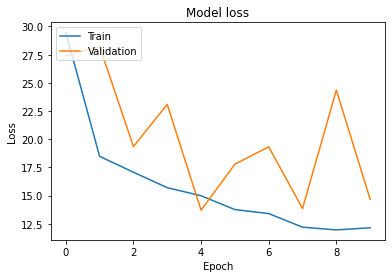

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

base_model = InceptionResNetV2(weights='imagenet', include_top=False)
input = Input(shape=(300,300,3),name='input1')
input_gender = Input(shape=(1,),dtype='float32',name='input2')
output = base_model(input)
#gender_embedding=Dense(16)(input_gender)
print (K.int_shape(output))
x=channel_attention(output)
print (K.int_shape(x))
x=spatial_attention(x)
print (K.int_shape(x))
x = keras.layers.MaxPooling2D(pool_size=(4,4))(x)
print (K.int_shape(x))
x=Flatten()(x)
#f= keras.layers.Concatenate(axis=1)([x,gender_embedding])
#print (K.int_shape(f)) 
x = Dense(256, activation='relu')(x)
prediction = Dense(1)(x)

model = Model(inputs=[input], outputs=prediction)
for i,layer in enumerate(model.layers):
    print (i,layer.name)

Adam=tf.keras.optimizers.Adam(lr=0.0003,beta_1=0.9,beta_2=0.999)
model.compile(optimizer=Adam, loss='mean_absolute_error', metrics=['MAE'])
model.summary()

checkpoint =keras.callbacks.ModelCheckpoint(filepath='weights_invres-img.{epoch:02d}-{val_loss:.2f}.hdf5',save_weights_only=True,period=10)
#model.fit_generator(DataGen.flow([x_train,gender_train],y_train,batch_size=batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=50,verbose=1,validation_data=([x_valid,gender_valid,agev],y_valid))
history=model.fit_generator(train_gen,  validation_data = (val_x, val_y), epochs = 10,  callbacks = checkpoint)
score = model.evaluate(test_X, test_Y, batch_size=batch_size)
print('Test loss:', score[0])
print('Test MAE:', score[1])
print('Test MAE:', score[1])

219055592/219055592 [==============================] - 8s 0us/step
(None, 8, 8, 1536)
(None, 8, 8, 1536)
(None, 8, 8, 1536)
(None, 2, 2, 1536)
0 input1
1 inception_resnet_v2
2 tf.math.reduce_mean_4
3 tf.math.reduce_max_4
4 dense_12
5 dense_14
6 dense_13
7 dense_15
8 tf.__operators__.add_2
9 tf.math.sigmoid_4
10 tf.math.multiply_4
11 tf.math.reduce_mean_5
12 tf.math.reduce_max_5
13 tf.concat_2
14 conv2d_393
15 tf.math.sigmoid_5
16 tf.math.multiply_5
17 max_pooling2d_14
18 flatten_2
19 dense_16
20 dense_17
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                             

<ipython-input-121-8231ee4d4c70>:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_gen,  validation_data = (val_x, val_y), epochs = 10,  callbacks = checkpoint)


Epoch 1/10
136/136 [==============================] - 155s 984ms/step - loss: 29.8250 - MAE: 29.8250 - val_loss: 60.0328 - val_MAE: 60.0328
Epoch 2/10
136/136 [==============================] - 133s 977ms/step - loss: 19.4649 - MAE: 19.4649 - val_loss: 21.0799 - val_MAE: 21.0799
Epoch 3/10
136/136 [==============================] - 129s 947ms/step - loss: 16.5889 - MAE: 16.5889 - val_loss: 16.3381 - val_MAE: 16.3381
Epoch 4/10
136/136 [==============================] - 134s 980ms/step - loss: 15.1950 - MAE: 15.1950 - val_loss: 15.9267 - val_MAE: 15.9267
Epoch 5/10
136/136 [==============================] - 130s 953ms/step - loss: 14.2221 - MAE: 14.2221 - val_loss: 21.6841 - val_MAE: 21.6841
Epoch 6/10
136/136 [==============================] - 130s 957ms/step - loss: 12.9354 - MAE: 12.9354 - val_loss: 12.0975 - val_MAE: 12.0975
Epoch 7/10
136/136 [==============================] - 133s 972ms/step - loss: 13.2574 - MAE: 13.2574 - val_loss: 8.8263 - val_MAE: 8.8263
Epoch 8/10
136/136 [==

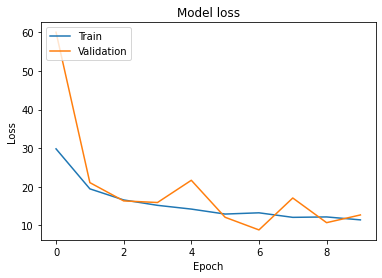

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
import tensorflow as tf
#from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

base_model = ResNet50(weights='imagenet', include_top=False)
input = Input(shape=(300,300,3),name='input1')
input_gender = Input(shape=(1,),dtype='float32',name='input2')
output = base_model(input)
#gender_embedding=Dense(16)(input_gender)
print (K.int_shape(output))
x=channel_attention(output)
print (K.int_shape(x))
x=spatial_attention(x)
print (K.int_shape(x))
x = keras.layers.MaxPooling2D(pool_size=(4,4))(x)
print (K.int_shape(x))
x=Flatten()(x)
#f= keras.layers.Concatenate(axis=1)([x,gender_embedding])
#print (K.int_shape(f)) 
x = Dense(256, activation='relu')(x)
prediction = Dense(1)(x)

model = Model(inputs=[input], outputs=prediction)
for i,layer in enumerate(model.layers):
    print (i,layer.name)

Adam=tf.keras.optimizers.Adam(lr=0.0003,beta_1=0.9,beta_2=0.999)
model.compile(optimizer=Adam, loss='mean_absolute_error', metrics=['MAE'])
model.summary()

checkpoint =keras.callbacks.ModelCheckpoint(filepath='weights_res-img.{epoch:02d}-{val_loss:.2f}.hdf5',save_weights_only=True,period=10)
#model.fit_generator(DataGen.flow([x_train,gender_train],y_train,batch_size=batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=50,verbose=1,validation_data=([x_valid,gender_valid,agev],y_valid))
history=model.fit_generator(train_gen,  validation_data = (val_x, val_y), epochs = 10,  callbacks = checkpoint)
score = model.evaluate(test_X, test_Y, batch_size=batch_size)
print('Test loss:', score[0])
print('Test MAE:', score[1])

94765736/94765736 [==============================] - 3s 0us/step
(None, 10, 10, 2048)
(None, 10, 10, 2048)
(None, 10, 10, 2048)
(None, 2, 2, 2048)
0 input1
1 resnet50
2 tf.math.reduce_mean_6
3 tf.math.reduce_max_6
4 dense_18
5 dense_20
6 dense_19
7 dense_21
8 tf.__operators__.add_3
9 tf.math.sigmoid_6
10 tf.math.multiply_6
11 tf.math.reduce_mean_7
12 tf.math.reduce_max_7
13 tf.concat_3
14 conv2d_394
15 tf.math.sigmoid_7
16 tf.math.multiply_7
17 max_pooling2d_15
18 flatten_3
19 dense_22
20 dense_23
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                    

<ipython-input-123-b095f7d97b82>:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_gen,  validation_data = (val_x, val_y), epochs = 10,  callbacks = checkpoint)


Epoch 1/10
136/136 [==============================] - 128s 881ms/step - loss: 27.8560 - MAE: 27.8560 - val_loss: 116.7692 - val_MAE: 116.7692
Epoch 2/10
136/136 [==============================] - 123s 900ms/step - loss: 21.1143 - MAE: 21.1143 - val_loss: 111.9017 - val_MAE: 111.9017
Epoch 3/10
136/136 [==============================] - 117s 862ms/step - loss: 18.4207 - MAE: 18.4207 - val_loss: 99.3177 - val_MAE: 99.3177
Epoch 4/10
136/136 [==============================] - 117s 855ms/step - loss: 17.2516 - MAE: 17.2516 - val_loss: 21.6504 - val_MAE: 21.6504
Epoch 5/10
136/136 [==============================] - 119s 874ms/step - loss: 15.1962 - MAE: 15.1962 - val_loss: 17.8826 - val_MAE: 17.8826
Epoch 6/10
136/136 [==============================] - 117s 856ms/step - loss: 15.4576 - MAE: 15.4576 - val_loss: 19.6618 - val_MAE: 19.6618
Epoch 7/10
136/136 [==============================] - 120s 882ms/step - loss: 15.5453 - MAE: 15.5453 - val_loss: 33.8747 - val_MAE: 33.8747
Epoch 8/10
136/1

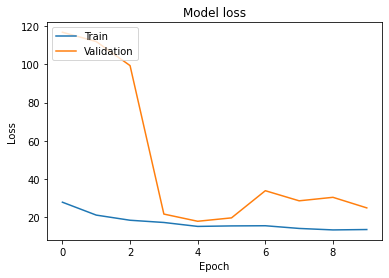

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()